In [119]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigh

from qiskit import transpile
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.operators import Operator
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit

from algo.utils import optimal_interp_points, interp_matrix

cite: Exploring Entanglement and Optimization within the Hamiltonian Variational
Ansatz

## $X X Z$ model

Another prototypical model for studying quantum magnetism is the XXZ model. For the 1D XXZ model, the Hamiltonian is given by

$$
\begin{aligned}
H_{\mathrm{XXZ}} & =\sum_{i=1}^N\left[\sigma_i^x \sigma_{i+1}^x+\sigma_i^y \sigma_{i+1}^y+\Delta \sigma_i^z \sigma_{i+1}^z\right] \\
& =H_{x x}+H_{y y}+\Delta H_{z z},
\end{aligned}
$$

with $H_{x x}=\sum_{i=1}^N \sigma_i^x \sigma_{i+1}^x, H_{y y}=\sum_{i=1}^N \sigma_i^y \sigma_{i+1}^y$ and $H_{z z}=$ $\sum_{i=1}^N \sigma_i^z \sigma_{i+1}^z$. Again, we assume periodic boundary conditions. The parameter $\Delta$ controls the spin anisotropy in the model. For $\Delta=1$, this model has an $S U(2)$ symmetry and is equivalent to the Heisenberg chain. For $\Delta \neq 1$, this symmetry gets reduced to a $U(1) \times \mathbb{Z}_2$ symmetry. For $1<|\Delta|$, the system is in the XY quasi-long-range ordered state and becomes gapless in the thermodynamic limit. At $|\Delta|=1$, there is a phase transition to the Néel ordered state. This model can be solved exactly using the Bethe ansatz for $N \rightarrow \infty[24]$.


In this work, we consider the problem of approximating the ground state at the critical points $g=1$ and $\Delta=1$ for the TFIM and the XXZ model, respectively, since their particular entanglement scaling properties makes them harder to approximate using classical methods [25], such as the density-matrix renormalization group (DMRG).

In [120]:
num_q = 4 # N # IMPORTANT

Delta = 0.5 # IMPORTANT
List_1 = []
op = ""
op = "X"
for k in range(num_q-2):
    op += "I"
op += "X"
List_1.append(op)
for i in range(num_q-1):
    op = ""
    for k in range(i):
        op += "I"
    op += "XX"
    for k in range(i+1,num_q-1):
        op += "I"
    List_1.append(op)
List_1.reverse()
H1 = SparsePauliOp(List_1, np.ones(num_q))

List_2 = []
op = "Y"
for k in range(num_q-2):
    op += "I"
op += "Y"
List_2.append(op)
for i in range(num_q-1):
    op = ""
    for k in range(i):
        op += "I"
    op += "YY"
    for k in range(i+1,num_q-1):
        op += "I"
    List_2.append(op)
List_2.reverse()
H2 = SparsePauliOp(List_2, np.ones(num_q))

H_first = SparsePauliOp.sum([H1,H2])

List_3 = []
op = "Z"
for k in range(num_q-2):
    op += "I"
op += "Z"
List_3.append(op)  
for i in range(num_q-1):
    op = ""
    for k in range(i):
        op += "I"
    op += "ZZ"
    for k in range(i+1,num_q-1):
        op += "I"
    List_3.append(op)

List_3.reverse()    
H_second = SparsePauliOp(List_3, Delta*np.ones(num_q))

# set H = H1 + H2
H = SparsePauliOp.sum([H_first,H_second])
Hmat = Operator(H)
Hmat = Hmat.data # This is the matrix representation of the Hamiltonian

# Print with detailed descriptions
print(f"Number of qubits (num_q): {num_q}")
print(f"Delta value: {Delta}")
print("List_1 (Pauli terms for XX interactions):")
print(List_1)
print("List_2 (Pauli terms for YY interactions):")
print(List_2)
print("List_3 (Pauli terms for ZZ interactions):")
print(List_3)
print(H.size)
print(H)

Number of qubits (num_q): 4
Delta value: 0.5
List_1 (Pauli terms for XX interactions):
['IIXX', 'IXXI', 'XXII', 'XIIX']
List_2 (Pauli terms for YY interactions):
['IIYY', 'IYYI', 'YYII', 'YIIY']
List_3 (Pauli terms for ZZ interactions):
['IIZZ', 'IZZI', 'ZZII', 'ZIIZ']
12
SparsePauliOp(['IIXX', 'IXXI', 'XXII', 'XIIX', 'IIYY', 'IYYI', 'YYII', 'YIIY', 'IIZZ', 'IZZI', 'ZZII', 'ZIIZ'],
              coeffs=[1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j,
 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


In [121]:
# Compute eigenvalues and eigenvectors
e, v = eigh(Hmat)

# Identify the ground state (minimum eigenvalue)
ground_e = np.min(e)
min_index = np.argmin(e)
v_min = v[:, min_index]  # Ground state eigenvector

# Check degeneracy of the ground state
degeneracy = np.sum(np.isclose(e, ground_e))

# Print warning if ground state is not unique
if degeneracy > 1:
    print(f"Warning: Ground state is not unique. Degeneracy = {degeneracy}. Fidelity is not good metric.")
else:
    print("Ground state is unique.")
    
# Optional: Output for debugging
print(f"Ground state energy: {ground_e}")
print(f"Eigenvalues: {e}")

Ground state is unique.
Ground state energy: -6.744562646538028
Eigenvalues: [-6.74456265e+00 -4.00000000e+00 -4.00000000e+00 -2.00000000e+00
 -3.94820641e-31 -1.27376008e-31 -1.18119571e-47  0.00000000e+00
  1.42519202e-33  9.02056208e-17  1.72746915e-16  2.00000000e+00
  2.00000000e+00  4.00000000e+00  4.00000000e+00  4.74456265e+00]


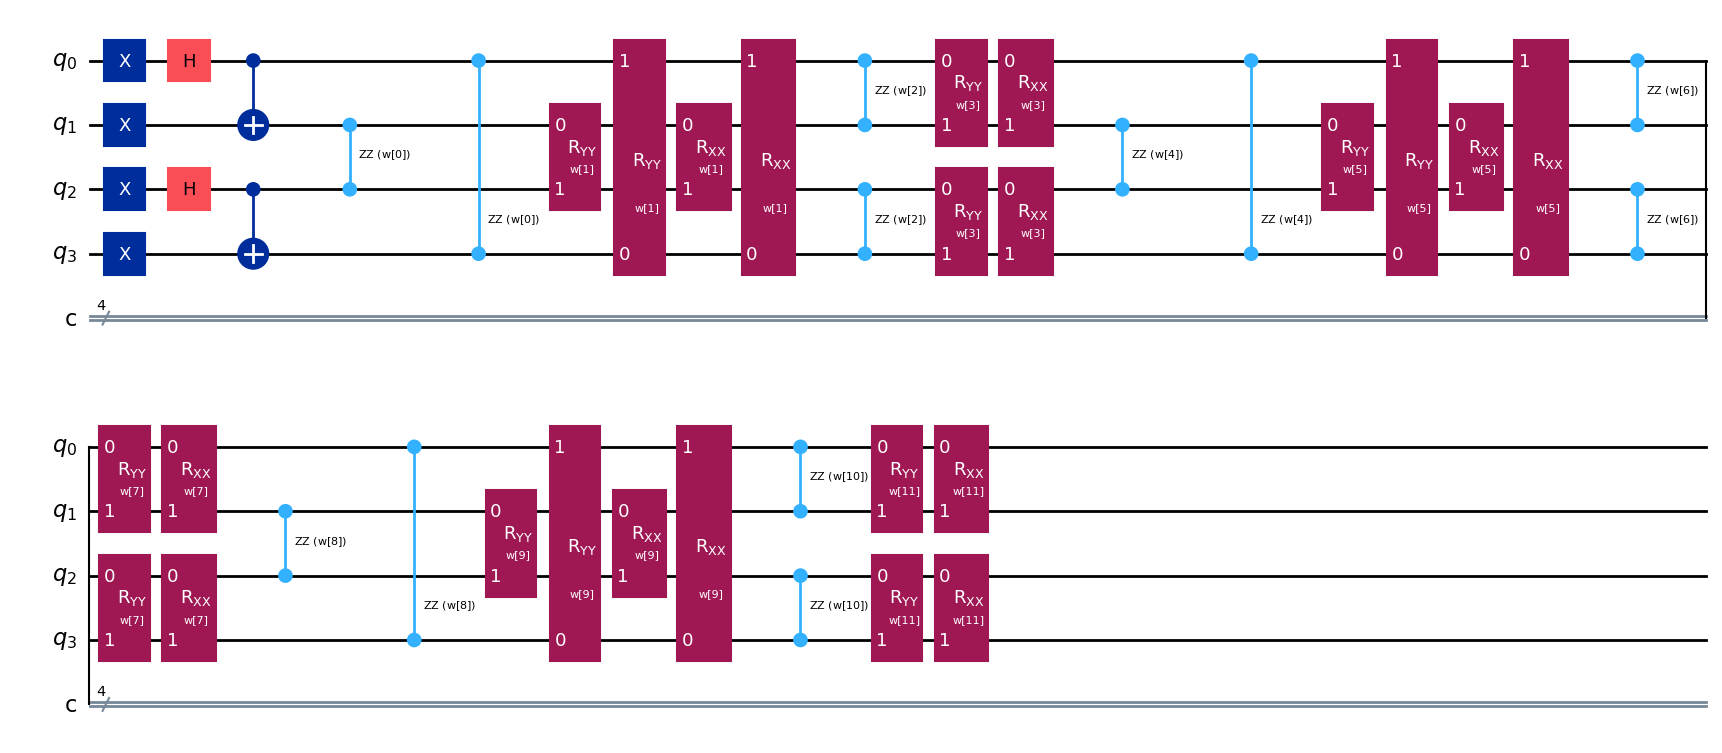

In [122]:
"""Circuit construction"""
layer = 3  # Define the number of layers in the quantum circuit

# This needs to be determined based on the circuit
num_p = layer * 4  # Calculate the number of parameters

weights = ParameterVector("w", num_p)  # Create a vector of parameters (parameters of the quantum circuit)

def circuit_QAOA_XXZ(weights):
    circ = QuantumCircuit(num_q, num_q)
    
    # Input layer to prepare Bell state -\psi
    for j in range(num_q):
        circ.x(j)  # Apply X gate to all qubits, initializing them from |0> to |1>.
    for j in range(int(num_q / 2)):
        # Then, for each pair of adjacent qubits (2j and 2j+1), apply H gate and CX (CNOT) gate to create Bell states.
        circ.h(2 * j)  # Apply Hadamard gate to each pair of qubits to create superposition states
        circ.cx(2 * j, 2 * j + 1)  # Create Bell state: Apply CNOT gate to each pair of qubits

    # QAOA Ansatz (variational layers)
    # Each layer consists of two parts: odd layers and even layers. The total number of layers is 'layer', with 2 sub-layers inside.
    for i in range(layer):
        ## Odd layers
        for j in range(int(num_q / 2)):
            circ.rzz(weights[4 * i], 2 * j + 1, (2 * j + 2) % num_q)  ## ZZ gates in odd sum
            # weights  [0]
        for j in range(int(num_q / 2)):
            circ.ryy(weights[4 * i + 1], 2 * j + 1, (2 * j + 2) % num_q)  ## YY gates in odd sum
            # weights  [1]
        for j in range(int(num_q / 2)):
            circ.rxx(weights[4 * i + 1], 2 * j + 1, (2 * j + 2) % num_q)  ## XX gates in odd sum
            # weights  [1]

        ## Even layers
        for j in range(int(num_q / 2)):
            circ.rzz(weights[4 * i + 2], 2 * j, 2 * j + 1)  ## ZZ gates in even sum
            # weights  [2]
        for j in range(int(num_q / 2)):
            circ.ryy(weights[4 * i + 3], 2 * j, 2 * j + 1)  ## YY gates in even sum
            # weights  [3]
        for j in range(int(num_q / 2)):
            circ.rxx(weights[4 * i + 3], 2 * j, 2 * j + 1)  ## XX gates in even sum
            # weights  [3]

    return circ 

qc = circuit_QAOA_XXZ(weights)
# print(qc)
qc.draw("mpl")


An efficient implementation is given below.

In [123]:
simulator = AerSimulator()

def estimate_loss(WEIGHTS, SHOTS):

    estimate_1 = 0
    estimate_2 = 0
    estimate_3 = 0

    ########################### XX
    qc = circuit_QAOA_XXZ(WEIGHTS)
    for i in range(num_q):
        qc.h(i)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc) ## output distribution of 0 and 1

    for i in range(SHOTS):
        c_i = c[i]

        for j in range(num_q-1):
            if c_i[num_q-1-j] == c_i[num_q-1-(j+1)]:
                estimate_1 += 1
            else:
                estimate_1 += -1
        
        if c_i[num_q-1-0] == c_i[num_q-1-(num_q-1)]:
            estimate_1 += 1
        else:
            estimate_1 += -1

    estimate_1 = estimate_1/SHOTS

    ########################### YY
    qc = circuit_QAOA_XXZ(WEIGHTS)
    for i in range(num_q):
        qc.sdg(i)
        qc.h(i)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc) ## output distribution of 0 and 1

    for i in range(SHOTS):
        c_i = c[i]

        for j in range(num_q-1):
            if c_i[num_q-1-j] == c_i[num_q-1-(j+1)]:
                estimate_2 += 1
            else:
                estimate_2 += -1
        
        if c_i[num_q-1-0] == c_i[num_q-1-(num_q-1)]:
            estimate_2 += 1
        else:
            estimate_2 += -1
            
    estimate_2 = estimate_2/SHOTS

    ########################### ZZ
    qc = circuit_QAOA_XXZ(WEIGHTS)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc) ## output distribution of 0 and 1

    for i in range(SHOTS):
        c_i = c[i]

        for j in range(num_q-1):
            if c_i[num_q-1-j] == c_i[num_q-1-(j+1)]:
                estimate_3 += 1
            else:
                estimate_3 += -1
        
        if c_i[num_q-1-0] == c_i[num_q-1-(num_q-1)]:
            estimate_3 += 1
        else:
            estimate_3 += -1
            
    estimate_3 = estimate_3/SHOTS

    
    estimate = estimate_1 + estimate_2 + Delta*estimate_3

    return estimate


def expectation_loss(WEIGHTS):
    qc = circuit_QAOA_XXZ(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    # ==========================================================================
    Hpsi = Hmat.dot(psi)
    expectation = np.inner(np.conjugate(psi),Hpsi)
    return np.real(expectation)


def fidelity(WEIGHTS):
    qc = circuit_QAOA_XXZ(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    # ==========================================================================
    return np.absolute(np.vdot(psi,v_min))**2


def std(WEIGHTS):
    qc = circuit_QAOA_XXZ(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    # ==========================================================================
    Hmat_sqaured =  Hmat @ Hmat
    Hmat_sqauredpsi = Hmat_sqaured.dot(psi)
    var = np.inner(np.conjugate(psi),Hmat_sqauredpsi) - expectation_loss(WEIGHTS)**2
    return np.sqrt(np.real(var))



In [124]:
weights = np.random.uniform(0, 2*np.pi, size=num_p)

print(expectation_loss(weights))
print(std(weights))
print(expectation_loss(weights)/std(weights))
print(ground_e)

# Check if the observed values from the simulator follow a normal distribution
# Essentially, this is to check whether the estimate_loss function is correct
# It takes a long time
shots = 1000
if False:
    true_value = expectation_loss(weights)

    num_trials = 3000
    estimate_results = [estimate_loss(weights, shots) for _ in range(num_trials)]

    plt.figure(figsize=(10, 6))
    plt.hist(estimate_results, bins=15, density=True, alpha=0.6, color='g', label='Estimation Results')
    plt.axvline(true_value, color='r', linestyle='--', label=f'True Value = {true_value}')
    plt.title('Distribution of estimate_Z outputs')
    plt.xlabel('Estimated Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()


1.2226135164336558
2.7048523291618616
0.45200749159289616
-6.744562646538028


In [125]:
weights_dict = {}

#################### Odd layers with RZZ gates
# omegas_1 = list(range(1, num_q // 2 + 1)) # Example: [1, 2]
# interp_nodes_1 = np.linspace(0, 2 * np.pi, 2 * len(omegas_1) + 1, endpoint=False)
# inverse_interp_matrix_1 = np.linalg.inv(interp_matrix(interp_nodes_1, omegas_1))

if num_q == 4:
    omegas = [2]
elif num_q == 6:
    omegas = [2]
elif num_q == 8:
    omegas = [2, 4]
elif num_q == 10:
    omegas = [2, 4]
elif num_q == 12:
    omegas = [2, 4, 6]
elif num_q == 14:
    omegas = [2, 4, 6]

omegas_1 = omegas
opt_mse, interp_nodes_1, inverse_interp_matrix_1 = optimal_interp_points(omegas_1)
print("Optimal MSE for omegas_1:", opt_mse)


#################### Even layers with RYY+RXX gates
# omegas_2 = list(range(1, (num_q // 2) * 2 + 1)) # Example: [1, 2, 3, 4]
# interp_nodes_2 = np.linspace(0, 2 * np.pi, 2 * len(omegas_2) + 1, endpoint=False)
# inverse_interp_matrix_2 = np.linalg.inv(interp_matrix(interp_nodes_2, omegas_2))

if num_q == 4:
    omegas = [2, 4]
elif num_q == 6:
    omegas = [2, 4]
elif num_q == 8:
    omegas = [2, 4, 6, 8]
elif num_q == 10:
    omegas = [2, 4, 6, 8]
elif num_q == 12:
    omegas = [2, 4, 6, 8, 10, 12]
elif num_q == 14:
    omegas = [2, 4, 6, 8, 10, 12]

omegas_2 = omegas
opt_mse, interp_nodes_2, inverse_interp_matrix_2 = optimal_interp_points(omegas_2)
print("Optimal MSE for omegas_2:", opt_mse)

# Construct weights_dict
weights_dict = {}
for j in range(num_p): 
    if j % 2 == 0:  # Odd layers with RZZ gates
        weights_dict[f'weights_{j}'] = {
            'omegas': omegas_1,
            'scale_factor': 2.0,
            'interp_nodes': interp_nodes_1,
            'inverse_interp_matrix': inverse_interp_matrix_1,
        }
    elif j % 2 == 1:  # Even layers with RYY+RXX gates
        weights_dict[f'weights_{j}'] = {
            'omegas': omegas_2,
            'scale_factor': 2.0,
            'interp_nodes': interp_nodes_2,
            'inverse_interp_matrix': inverse_interp_matrix_2,
        }
    
    # # Save weights_dict to a file
    # with open(weights_dict_file, 'wb') as file:
    #     pickle.dump(weights_dict, file)
    # print("Generated and saved weights_dict to weights_dict.pkl")

# Print example results
print(weights_dict['weights_0'])
print(weights_dict['weights_1'])
print(len(weights_dict))
print(num_q)

Optimal MSE for omegas_1: 1.999998666667576
Optimal MSE for omegas_2: 1.9999992000003202
{'omegas': [2], 'scale_factor': 2.0, 'interp_nodes': [3.5694687375908627, 4.616666320698158, 5.663863925727047], 'inverse_interp_matrix': array([[ 0.47140449,  0.47140457,  0.4714045 ],
       [ 0.43710046, -0.6544868 ,  0.21738634],
       [ 0.50337626,  0.12685198, -0.63022824]])}
{'omegas': [2, 4], 'scale_factor': 2.0, 'interp_nodes': [1.9878028485031356, 2.61612137586887, 3.2444399031749773, 3.872758435926772, 4.50107697375285], 'inverse_interp_matrix': array([[ 0.28284271,  0.28284271,  0.28284271,  0.28284272,  0.28284271],
       [-0.26876359,  0.19870129,  0.39156775,  0.04330088, -0.36480633],
       [-0.29625349, -0.34715673,  0.08169883,  0.39764939,  0.164062  ],
       [-0.03883065, -0.20258898,  0.36662651, -0.39062516,  0.26541829],
       [ 0.39811077, -0.34490246,  0.15995314,  0.08609285, -0.29925429]])}
12
4


In [126]:
# # Verify if the function can be accurately interpolated by trigonometric interpolation based on omegas

# from algo.utils import check_is_trigometric  # Assuming check_is_trigometric is defined in utils module

# # Define random weights
# weights = np.random.normal(0, 4 * np.pi**2, num_p)

# # Loop over each weight index and check trigonometric interpolation
# for j in range(num_p):
#     # Circuit_HEA is simple and all Hermitian generators are Y.
#     omegas = weights_dict[f'weights_{j}']['omegas']  # This needs to be determined based on the circuit (i.e., parameters to test interpolation)
    
#     print('\n index to check = ', j)
#     print('omegas = ', omegas)
    
#     opt_interp_flag = False  # Flag to indicate if optimal interpolation should be used
    
#     # Call the function to check if the objective function can be interpolated using trigonometric interpolation
#     check_is_trigometric(expectation_loss, j, omegas, weights, opt_interp_flag)



In [127]:
# initial_weights = np.zeros(num_p) #np.ones(num_p)
initial_weights = np.random.uniform(0, 2*np.pi, size=num_p)
n_shot = 1000
print(f"Ground state energy: {ground_e}")

Ground state energy: -6.744562646538028


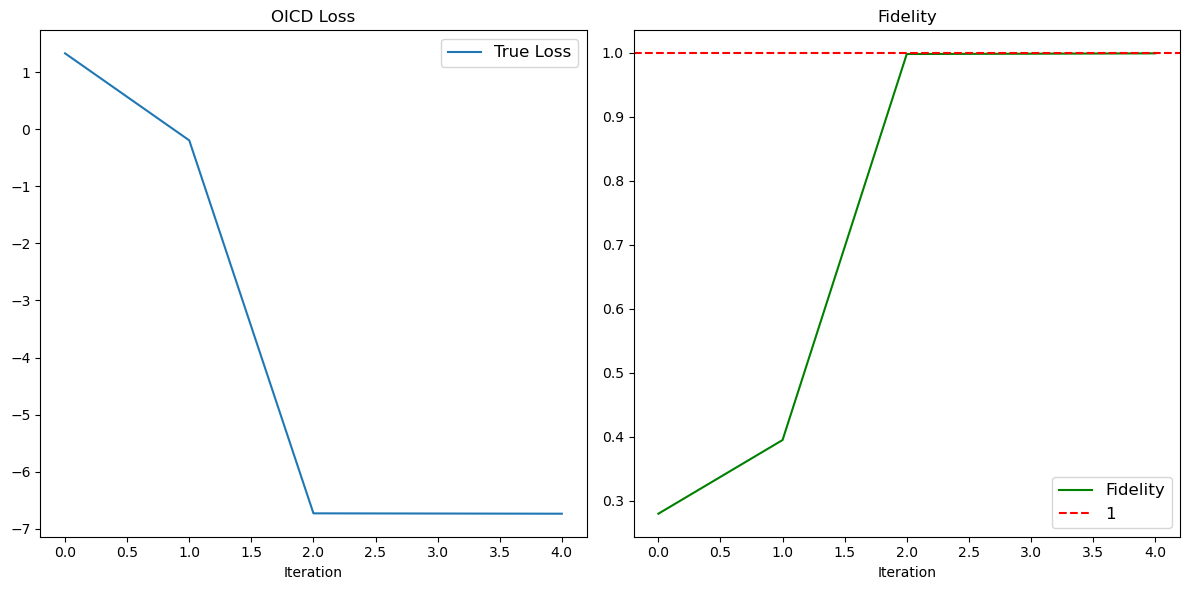

[OICD] Iter: 3, 0(12), Best loss: -6.7380, Cur. loss: -6.7380, Best Fid.: 0.9991, Cur. Fid.: 0.9991:   0%|          | 3/15000 [00:01<2:25:33,  1.72it/s]


In [128]:
# OICD Optimization
from algo.oicd import oicd

num_iter = 15000
# Run OICD
final_weights_oicd, best_expected_record_value_oicd, fidelity_record_value_oicd, func_oicd, expected_every_oicd, fid_every_oicd = oicd(
    estimate_loss,
    expectation_loss,
    fidelity,
    n_shot, weights_dict, initial_weights, num_iter,
    cyclic_mode=False,
    use_pratical_interp_flag=True,
    use_local_solvers_flag=False,
    use_global_solvers_flag = False,
    use_eigen_method_flag = True,
    # subproblem_method='BFGS',
    # subproblem_iter=None,
    use_exact_update_frequencey_1_flag = False,
    exact_mode=False, # for testing purpose, no noisy loss
    plot_flag=True,
    plot_argmin_flag = False,
)


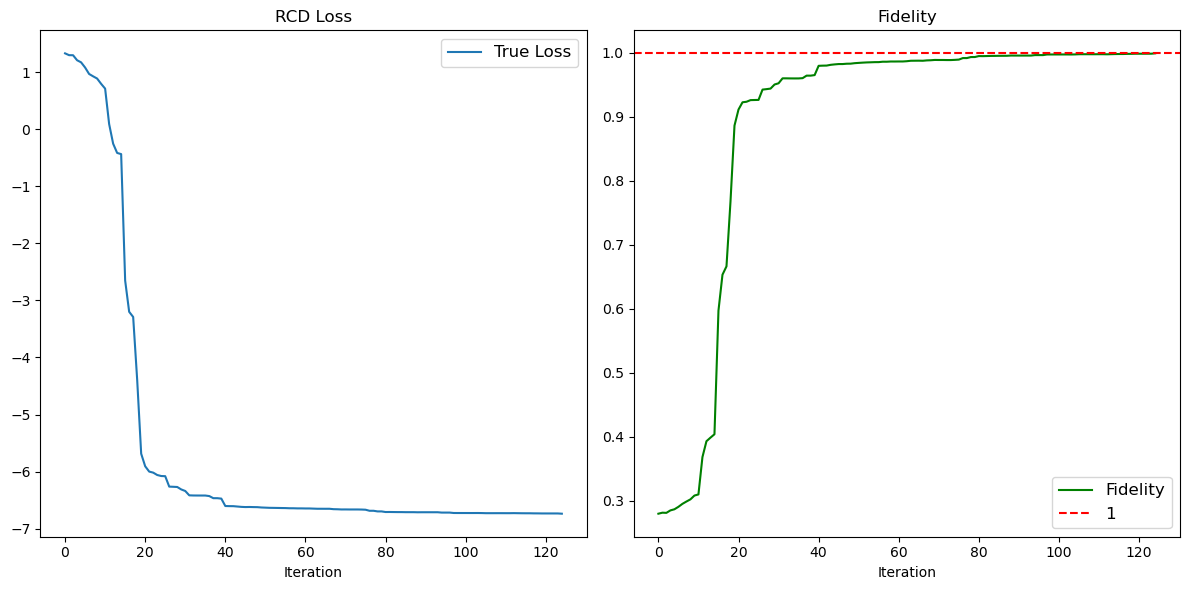

[RCD] Iter: 123, 9(12), Best loss: -6.7388, Cur. loss: -6.7388, Best Fid.: 0.9992, Cur. Fid.: 0.9992:   1%|          | 123/15000 [00:59<2:00:09,  2.06it/s]


In [129]:
# RCD Optimization
from algo.rcd import rcd

num_iter = 15000
# Run RCD
final_weights_rcd, best_expected_record_value_rcd, fidelity_record_value_rcd, func_rcd, expected_every_rcd, fid_every_rcd = rcd(
    estimate_loss,
    expectation_loss,
    fidelity,
    n_shot, weights_dict, initial_weights, num_iter,
    cyclic_mode=False,
    learning_rate=0.01,
    decay_step=10,
    decay_rate=-1,
    decay_threshold=1e-4,
    exact_mode=False,
    plot_flag=True,
)


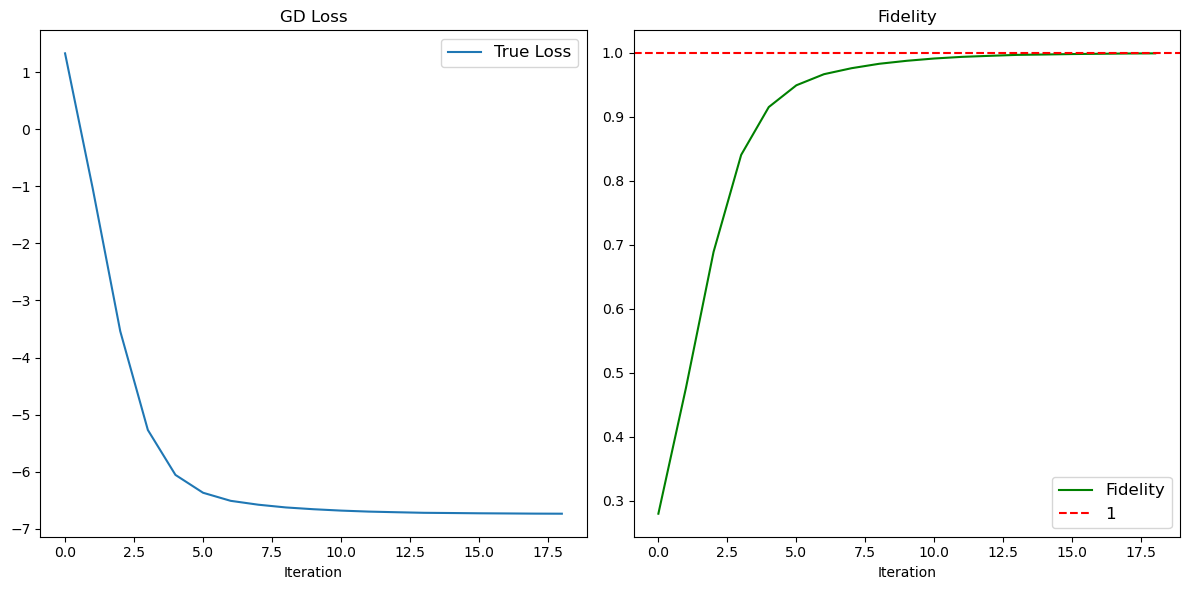

[GD] Iter: 17, Best loss: -6.7379, Cur. loss: -6.7379, Best Fid.: 0.9991, Cur. Fid.: 0.9991:   0%|          | 17/15000 [00:47<11:41:46,  2.81s/it]


In [130]:
# Gradient Descent Optimization
from algo.gd import gd

num_iter = 15000
# Run GD
final_weights_gd, best_expected_record_value_gd, fidelity_record_value_gd, func_gd, expected_every_gd, fid_every_gd  = gd(
    estimate_loss,
    expectation_loss,
    fidelity,
    n_shot, weights_dict, initial_weights, num_iter,
    learning_rate=0.005,
    exact_mode=False,
    plot_flag=True,
)


## best_expected

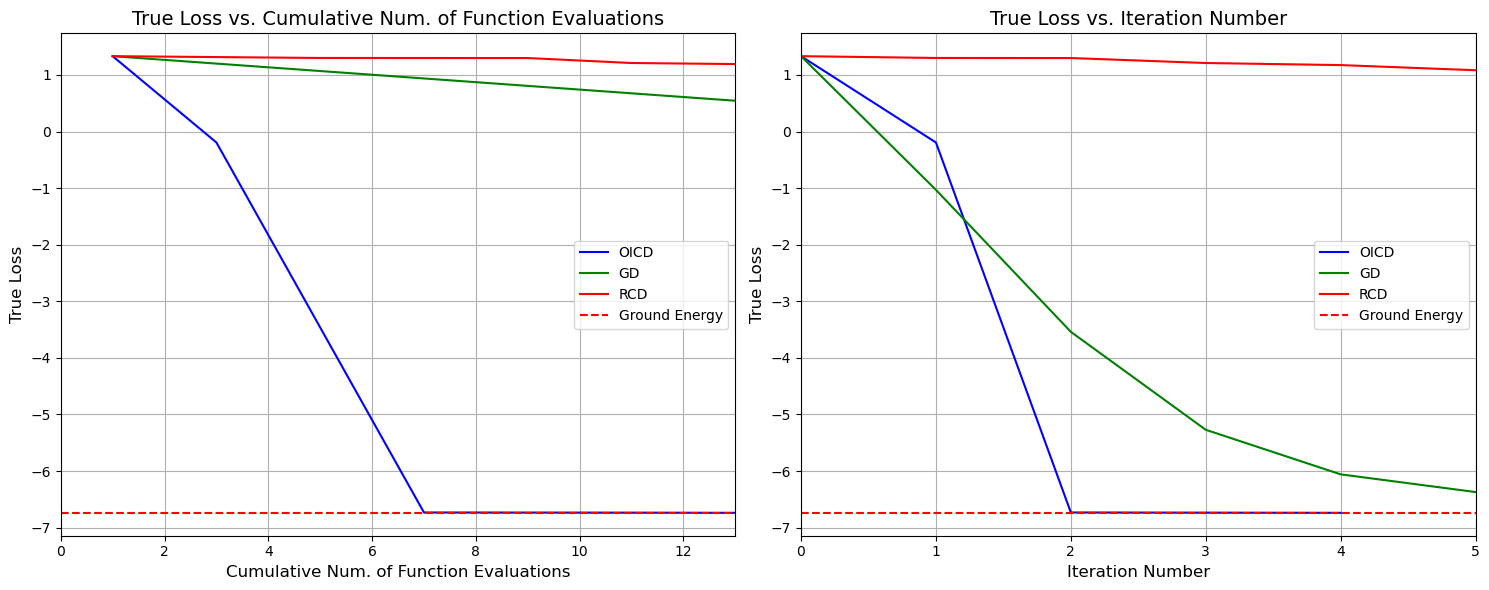

In [131]:
# Create a 1x2 subplot layout
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# First subplot: x-axis is the cumulative number of function evaluations, y-axis is the function value
axs[0].plot(func_oicd, best_expected_record_value_oicd, label='OICD', color='blue')
axs[0].plot(func_gd, best_expected_record_value_gd, label='GD', color='green')
axs[0].plot(func_rcd, best_expected_record_value_rcd, label='RCD', color='red')
axs[0].axhline(y=ground_e, color='r', linestyle='--', label='Ground Energy')

# Set labels and title for the first subplot
axs[0].set_xlabel('Cumulative Num. of Function Evaluations', fontsize=12)
axs[0].set_ylabel('True Loss', fontsize=12)
axs[0].set_title('True Loss vs. Cumulative Num. of Function Evaluations', fontsize=14)

# Set the x-axis range
# x_range = np.average([func_oicd[-1], func_gd[-1], func_rcd[-1]])
# x_range = max(func_oicd[-1], func_gd[-1], func_rcd[-1])
# x_range = min(func_oicd[-1], func_gd[-1], func_rcd[-1])
x_range = func_oicd[-1]*1
axs[0].set_xlim(0, x_range)

# Display the legend for the first subplot
axs[0].legend()

# Second subplot: x-axis is the iteration number, y-axis is the function value
axs[1].plot(best_expected_record_value_oicd, label='OICD', color='blue')
axs[1].plot(best_expected_record_value_gd, label='GD', color='green')
axs[1].plot(best_expected_record_value_rcd, label='RCD', color='red')
axs[1].axhline(y=ground_e, color='r', linestyle='--', label='Ground Energy')

# Set labels and title for the second subplot
axs[1].set_xlabel('Iteration Number', fontsize=12)
axs[1].set_ylabel('True Loss', fontsize=12)
axs[1].set_title('True Loss vs. Iteration Number', fontsize=14)

# Set the x-axis range
axs[1].set_xlim(0, min(len(best_expected_record_value_oicd), len(best_expected_record_value_gd), len(best_expected_record_value_rcd)))

# Display the legend for the second subplot
axs[1].legend()

# Display grid lines
for ax in axs:
    ax.grid(True)

# Adjust the layout automatically to avoid overlapping labels between subplots
plt.tight_layout()

# Show the plot
plt.show()


## best_fid

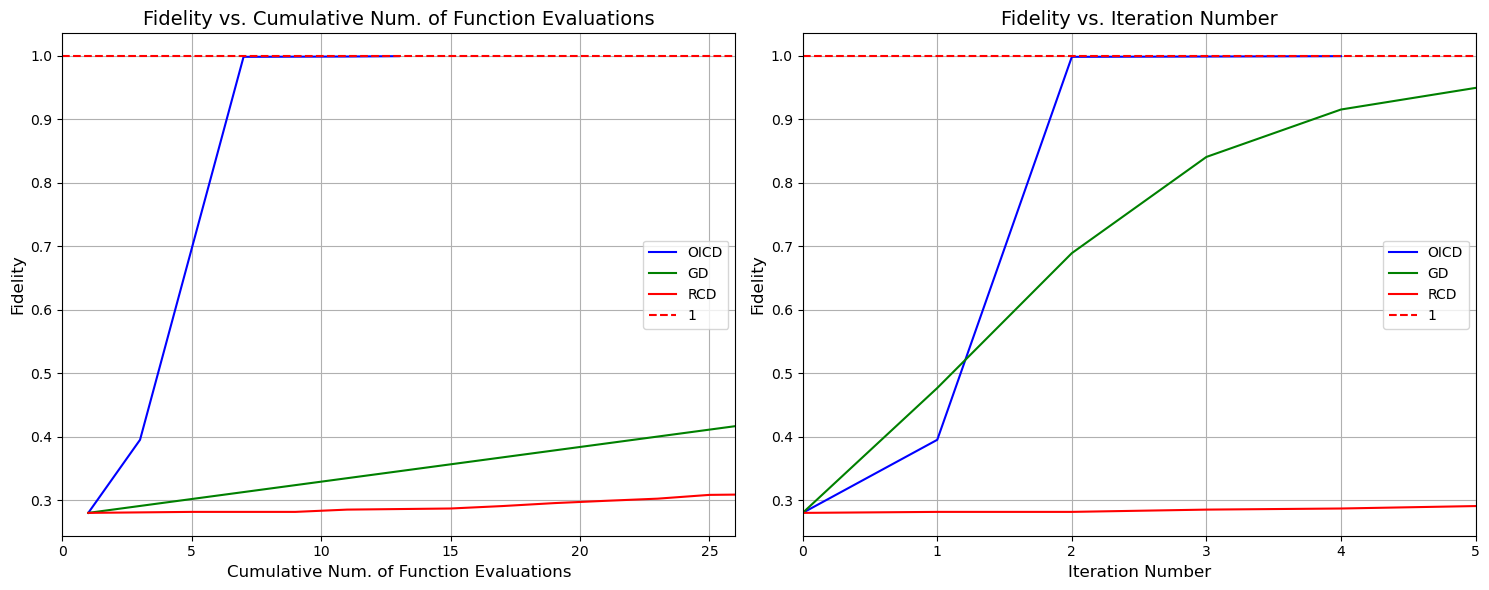

In [132]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# First subplot: x-axis is the cumulative number of function evaluations, y-axis is Fidelity
axs[0].plot(func_oicd, fidelity_record_value_oicd, label='OICD', color='blue')
axs[0].plot(func_gd, fidelity_record_value_gd, label='GD', color='green')
axs[0].plot(func_rcd, fidelity_record_value_rcd, label='RCD', color='red')
axs[0].axhline(y=1, color='r', linestyle='--', label='1')

# Set labels and title for the first subplot
axs[0].set_xlabel('Cumulative Num. of Function Evaluations', fontsize=12)
axs[0].set_ylabel('Fidelity', fontsize=12)
axs[0].set_title('Fidelity vs. Cumulative Num. of Function Evaluations', fontsize=14)

# Set the x-axis range
# x_range = np.average([func_oicd[-1], func_gd[-1], func_rcd[-1]])
# x_range = max(func_oicd[-1], func_gd[-1], func_rcd[-1])
# x_range = min(func_oicd[-1], func_gd[-1], func_rcd[-1])
x_range = func_oicd[-1]*2
axs[0].set_xlim(0, x_range)

# Display the legend for the first subplot
axs[0].legend()

# Second subplot: x-axis is the iteration number, y-axis is Fidelity
axs[1].plot(fidelity_record_value_oicd, label='OICD', color='blue')
axs[1].plot(fidelity_record_value_gd, label='GD', color='green')
axs[1].plot(fidelity_record_value_rcd, label='RCD', color='red')
axs[1].axhline(y=1, color='r', linestyle='--', label='1')

# Set labels and title for the second subplot
axs[1].set_xlabel('Iteration Number', fontsize=12)
axs[1].set_ylabel('Fidelity', fontsize=12)
axs[1].set_title('Fidelity vs. Iteration Number', fontsize=14)

# Set the x-axis range
axs[1].set_xlim(0, min(len(fidelity_record_value_oicd), len(fidelity_record_value_gd), len(fidelity_record_value_rcd)))

# Display the legend for the second subplot
axs[1].legend()

# Display grid lines
for ax in axs:
    ax.grid(True)

# Automatically adjust layout to avoid overlap
plt.tight_layout()

# Display the plot
plt.show()


## expected_every

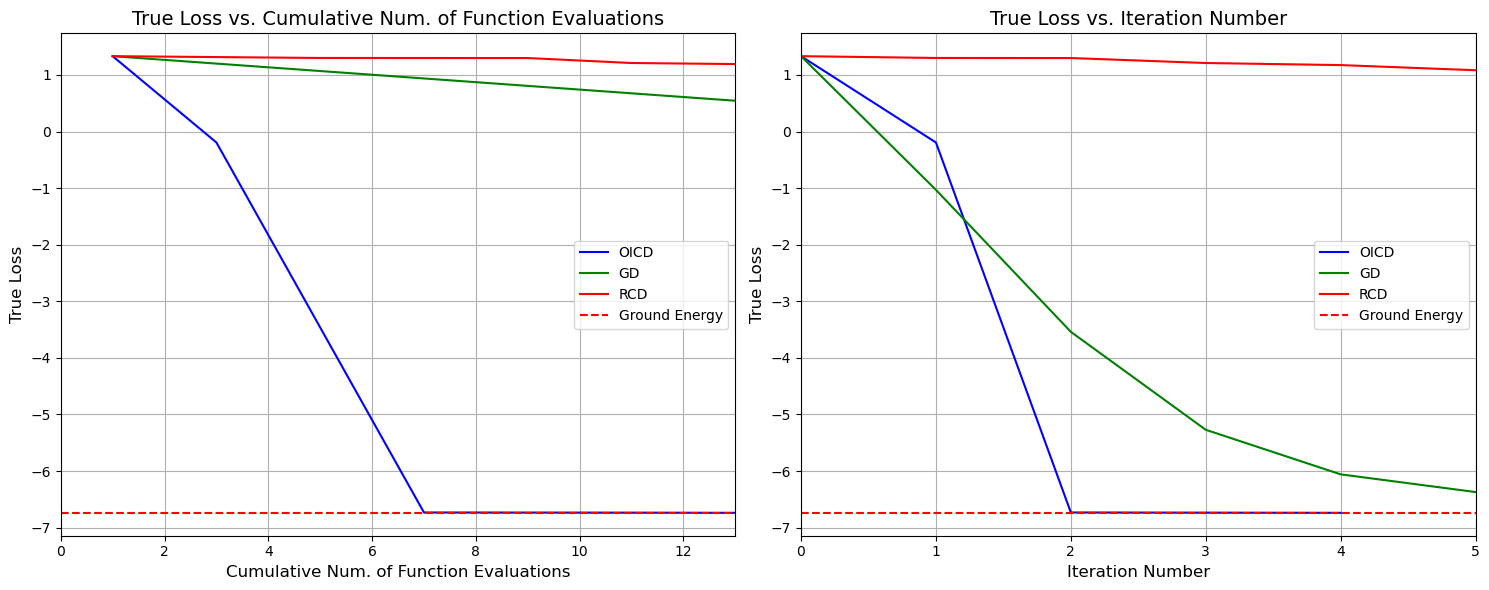

In [133]:
# Create a 1x2 subplot layout
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# First subplot: x-axis is the cumulative number of function evaluations, y-axis is the function value
axs[0].plot(func_oicd, expected_every_oicd, label='OICD', color='blue')
axs[0].plot(func_gd, expected_every_gd, label='GD', color='green')
axs[0].plot(func_rcd, expected_every_rcd, label='RCD', color='red')
axs[0].axhline(y=ground_e, color='r', linestyle='--', label='Ground Energy')

# Set labels and title for the first subplot
axs[0].set_xlabel('Cumulative Num. of Function Evaluations', fontsize=12)
axs[0].set_ylabel('True Loss', fontsize=12)
axs[0].set_title('True Loss vs. Cumulative Num. of Function Evaluations', fontsize=14)

# Set the x-axis range
# x_range = np.average([func_oicd[-1], func_gd[-1], func_rcd[-1]])
# x_range = max(func_oicd[-1], func_gd[-1], func_rcd[-1])
# x_range = min(func_oicd[-1], func_gd[-1], func_rcd[-1])
x_range = func_oicd[-1]*1
axs[0].set_xlim(0, x_range)

# Display the legend for the first subplot
axs[0].legend()

# Second subplot: x-axis is the iteration number, y-axis is the function value
axs[1].plot(expected_every_oicd, label='OICD', color='blue')
axs[1].plot(expected_every_gd, label='GD', color='green')
axs[1].plot(expected_every_rcd, label='RCD', color='red')
axs[1].axhline(y=ground_e, color='r', linestyle='--', label='Ground Energy')

# Set labels and title for the second subplot
axs[1].set_xlabel('Iteration Number', fontsize=12)
axs[1].set_ylabel('True Loss', fontsize=12)
axs[1].set_title('True Loss vs. Iteration Number', fontsize=14)

# Set the x-axis range
axs[1].set_xlim(0, min(len(expected_every_oicd), len(expected_every_gd), len(expected_every_rcd)))

# Display the legend for the second subplot
axs[1].legend()

# Display grid lines
for ax in axs:
    ax.grid(True)

# Adjust the layout automatically to avoid overlapping labels between subplots
plt.tight_layout()

# Show the plot
plt.show()


## fid_every

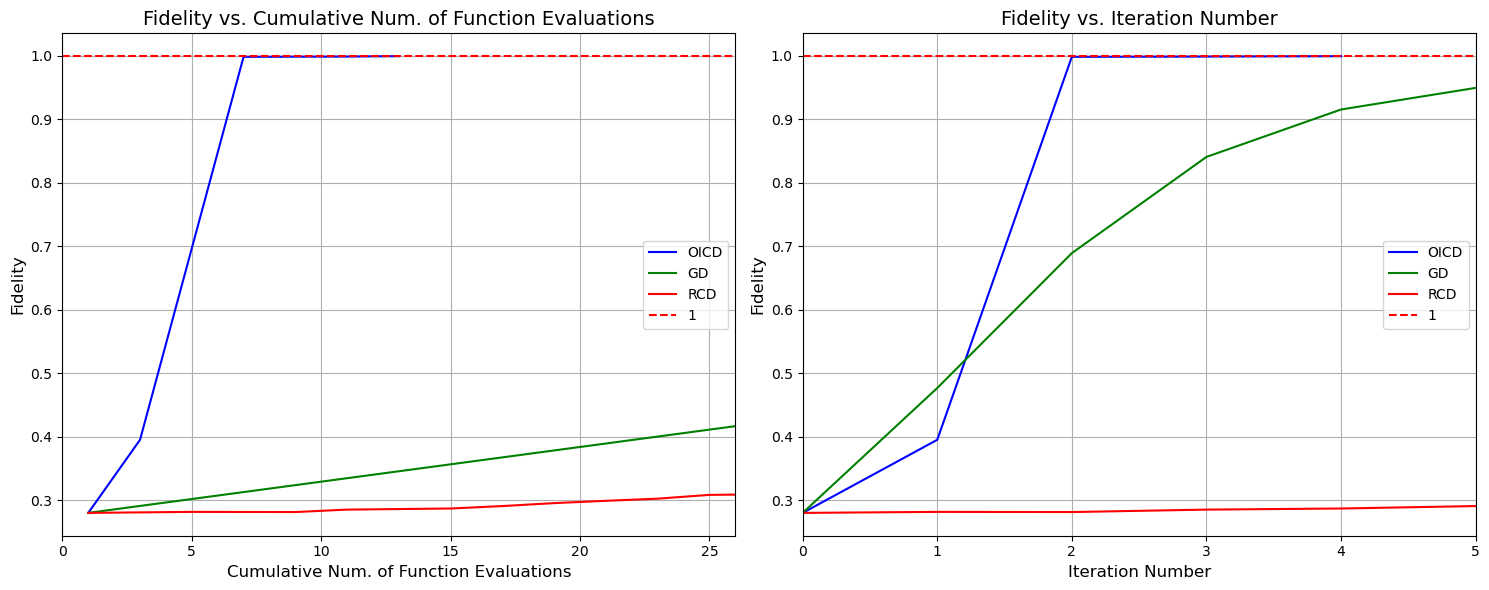

In [134]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# First subplot: x-axis is the cumulative number of function evaluations, y-axis is Fidelity
axs[0].plot(func_oicd, fid_every_oicd, label='OICD', color='blue')
axs[0].plot(func_gd, fid_every_gd, label='GD', color='green')
axs[0].plot(func_rcd, fid_every_rcd, label='RCD', color='red')
axs[0].axhline(y=1, color='r', linestyle='--', label='1')

# Set labels and title for the first subplot
axs[0].set_xlabel('Cumulative Num. of Function Evaluations', fontsize=12)
axs[0].set_ylabel('Fidelity', fontsize=12)
axs[0].set_title('Fidelity vs. Cumulative Num. of Function Evaluations', fontsize=14)

# Set the x-axis range
# x_range = np.average([func_oicd[-1], func_gd[-1], func_rcd[-1]])
# x_range = max(func_oicd[-1], func_gd[-1], func_rcd[-1])
# x_range = min(func_oicd[-1], func_gd[-1], func_rcd[-1])
x_range = func_oicd[-1]*2
axs[0].set_xlim(0, x_range)

# Display the legend for the first subplot
axs[0].legend()

# Second subplot: x-axis is the iteration number, y-axis is Fidelity
axs[1].plot(fid_every_oicd, label='OICD', color='blue')
axs[1].plot(fid_every_gd, label='GD', color='green')
axs[1].plot(fid_every_rcd, label='RCD', color='red')
axs[1].axhline(y=1, color='r', linestyle='--', label='1')

# Set labels and title for the second subplot
axs[1].set_xlabel('Iteration Number', fontsize=12)
axs[1].set_ylabel('Fidelity', fontsize=12)
axs[1].set_title('Fidelity vs. Iteration Number', fontsize=14)

# Set the x-axis range
axs[1].set_xlim(0, min(len(fid_every_oicd), len(fid_every_gd), len(fid_every_rcd)))

# Display the legend for the second subplot
axs[1].legend()

# Display grid lines
for ax in axs:
    ax.grid(True)

# Automatically adjust layout to avoid overlap
plt.tight_layout()

# Display the plot
plt.show()
